# Online Gamestore Analysis

You work for the online store Ice, which sells video games all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. You need to identify patterns that determine whether a game succeeds or not. This will allow you to spot potential big winners and plan advertising campaigns.

In front of you is data going back to 2016. Let’s imagine that it’s December 2016 and you’re planning a campaign for 2017.

(The important thing is to get experience working with data. It doesn't really matter whether you're forecasting 2017 sales based on data from 2016 or 2017 sales based on data from 2016.)

The dataset contains the abbreviation ESRB. The Entertainment Software Rating Board evaluates a game's content and assigns an age rating such as Teen or Mature.

## Open the Data File

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")



games = pd.read_csv('/datasets/games.csv')

display(games.head())
display(games.info())

games.duplicated().sum()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

0

The data includes 16715 entries, including name, platform, year of release, and genre. There are sales in USD millions from North America (NA), Europe (EU), Japan (JP), and other countries (Other). Critic score is out of 100 and user score is out of 10.There are missing values in the columns, 'Name', 'Year_of_Release', 'Genre', 'Critic_Score', 'User_Score', and 'Rating'. The two types of data are object type and float type. There are no duplicates in the data.

## Prepare the Data

### Deal With Missing Values

In [2]:
#Change column names to lower case
games.set_axis(
    ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score',
     'user_score', 'rating'], axis = 'columns', inplace = True
)

#Remove missing values from year of release
games['year_of_release'].isnull().sum()

#Remove missing values from columns 'year_of_release', 'name', and 'genre'
games.dropna(subset = ['name', 'genre', 'year_of_release'], inplace = True)

#Fill missing values from column 'user_score'
games['user_score'] = games['user_score'].replace('tbd', np.nan)
games['user_score'] = games['user_score'].astype(float)
games['user_score'] = games.groupby('name')['user_score'].transform(lambda grp: grp.fillna(np.mean(grp)))

#Fill missing values from column 'critic_score'
games['critic_score'] = games.groupby('name')['critic_score'].transform(lambda grp: grp.fillna(np.mean(grp)))

#Fill missing values from column 'rating'
games['rating'] = games['rating'].fillna('NA')

display(games.head())
display(games.info())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NA
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NA


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null float64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       8922 non-null float64
user_score         8524 non-null float64
rating             16444 non-null object
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


None

We removed the missing values in the columns 'name', 'genre', 'year_of_release'. There were only two missing values in the columns 'name' and 'genre'. The amount of missing values in the column 'year_of_release' was less than 2% so it will not affect the analysis. For the column 'user_score' there were to be determined values, which we replaced with nan values. We replaced as many values as we could in the columns 'user_score' and 'critic_score' with the average score of games with the same name. The rest of the values in columns 'user_score' and 'critic_score' were left as nan values. We replaced the missing values in 'rating' with the value 'NA' since we do not know the the rating of these games.

Many rows are missing values from all three columns 'critic_score', 'user_score', and 'rating'. Since, all three values are missing from over half the data we can speculate that the values are missing due to human error.

### Convert Data Types

In [3]:
#Change data types in 'year_of_release'
games['year_of_release'] = games['year_of_release'].astype(int)
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       8922 non-null float64
user_score         8524 non-null float64
rating             16444 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


We changed the data type to int in the column 'year_of_release'. This gets rid of the decimal and makes the data look nicer. In the above section we changed the data in 'user_score' to data type float so we could use mathematical calculations on the column.

### Calculate the Total Sales

In [4]:
#Calculate the total sales per game
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NA,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NA,31.38


We added the column 'total_sales' by combining the sales from all regions for each game.

## Analyze the Data

### Look at how Many Games were Released in Different Years

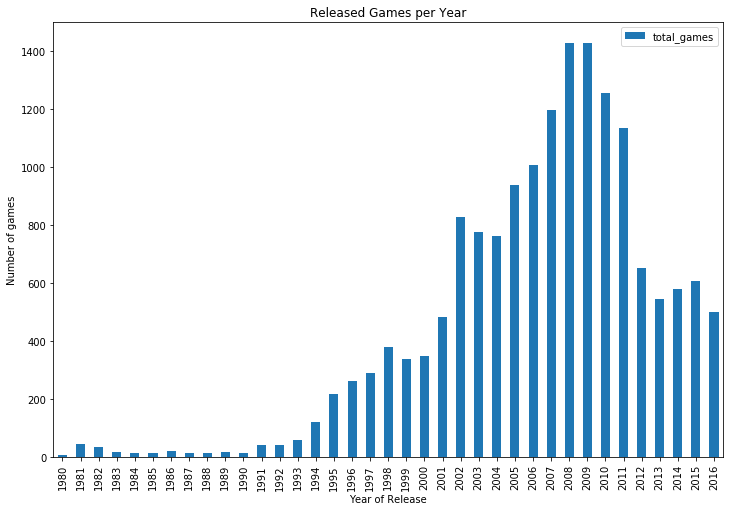

In [5]:
#Games released per year
games_per_year = games.groupby('year_of_release')['name'].count().reset_index()
games_per_year.columns = ['year_of_release', 'total_games']
games_per_year.head()
#Plot of games released per year
games_per_year.plot(kind = 'bar', x = 'year_of_release', y = 'total_games', figsize = (12, 8))
plt.xlabel('Year of Release')
plt.ylabel('Number of games')
plt.title('Released Games per Year')
plt.show()

To see how many games were release per year, we created a bar graph that shows the number of games realeased each year. The title of the graph is "Released Games per Year". The x axis is years of release and the y axis is number of games. Data after the year 2000 is more significant compared to early years. The most games werer sold from the time period of 2005 to 2011. There is a decrease in games sold after 2011.

### Look at how Sales Varied from Platform to Platform

,platform,total_sales
16,PS2,1233.56
28,X360,961.24
17,PS3,931.34
26,Wii,891.18
4,DS,802.78
15,PS,727.58
18,PS4,314.14
6,GBA,312.88
19,PSP,289.53
2,3DS,257.81


Text(0.5, 1.0, 'Total Sales per Platform')

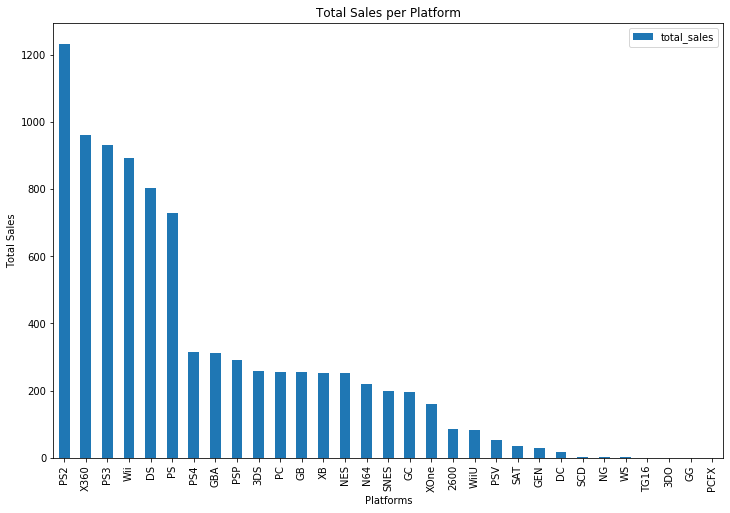

In [6]:
#Sales per platform
sales_per_platform = games.groupby('platform')['total_sales'].sum().reset_index().sort_values(by = 'total_sales', ascending = False)
display(sales_per_platform.head(10))
#Plot of sales per platform
sales_per_platform.plot(kind = 'bar', x = 'platform', y = 'total_sales', figsize = (12,8))
plt.ylabel('Total Sales')
plt.xlabel('Platforms')
plt.title('Total Sales per Platform')

To see the total sales per platform, we formed a bar graph showing the total sales that each platform made. The graph is titled "Total Sales per Platform", the x axis shows platforms and the y axis shows total sales. The platforms with the highest sales are PS2 and DS. The platforms with the lowest sales are fairly older platforms. 

### Find Platforms with the Greastest Total Sales and Build a Distribution Based on Data from Each Year

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

,platform,year_of_release,total_sales
0,DS,1985,0.02
1,DS,2004,17.27
2,DS,2005,130.14
3,DS,2006,119.81
4,DS,2007,146.94


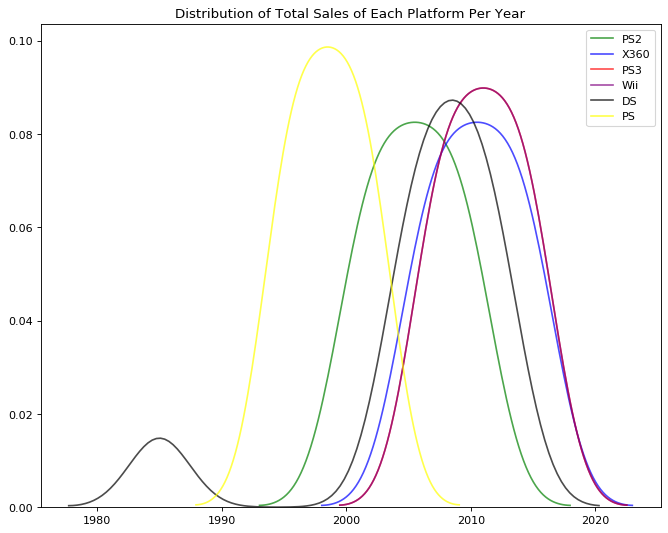

In [7]:
#Top 7 platforms
top_platforms = sales_per_platform.head(6)['platform'].tolist()
display(top_platforms)
#Total sales of each platform per year
greatest_sales = games.query('platform in @top_platforms')[['platform', 'year_of_release', 'total_sales']]
greatest_sales = pd.pivot_table(greatest_sales, values = ['total_sales'], index = ['platform', 'year_of_release'],
                                aggfunc = 'sum').reset_index()

display(greatest_sales.head())
#Plot total sales of each platform per year
plt.figure(figsize = (10, 8), dpi = 80)
colors = ['green', 'blue', 'red', 'purple', 'black', 'yellow']
i = 0
for platform in top_platforms:
    top_platform_sales = greatest_sales.loc[greatest_sales['platform'] == platform, 'year_of_release']
    sns.kdeplot(top_platform_sales, shade = False, color = colors[i], label = platform, alpha = 0.7)
    i += 1
    
plt.title('Distribution of Total Sales of Each Platform Per Year')
plt.legend()
plt.show()


The top 7 platforms with the highest sales are the PS2, DS, PS3, Wii, X360, PSP, and PS. To show distribution of highest platforms per year, I built a density histogram. This shows the distribution of total sales per year for each platform. The total sales is highest in the year 1998 for the platform PS because it is an older system. Whereas, all the other highest selling platforms have their highest point between 2004-2013.

### Find Platforms that Use to be Popular but Now Have Zero Sales

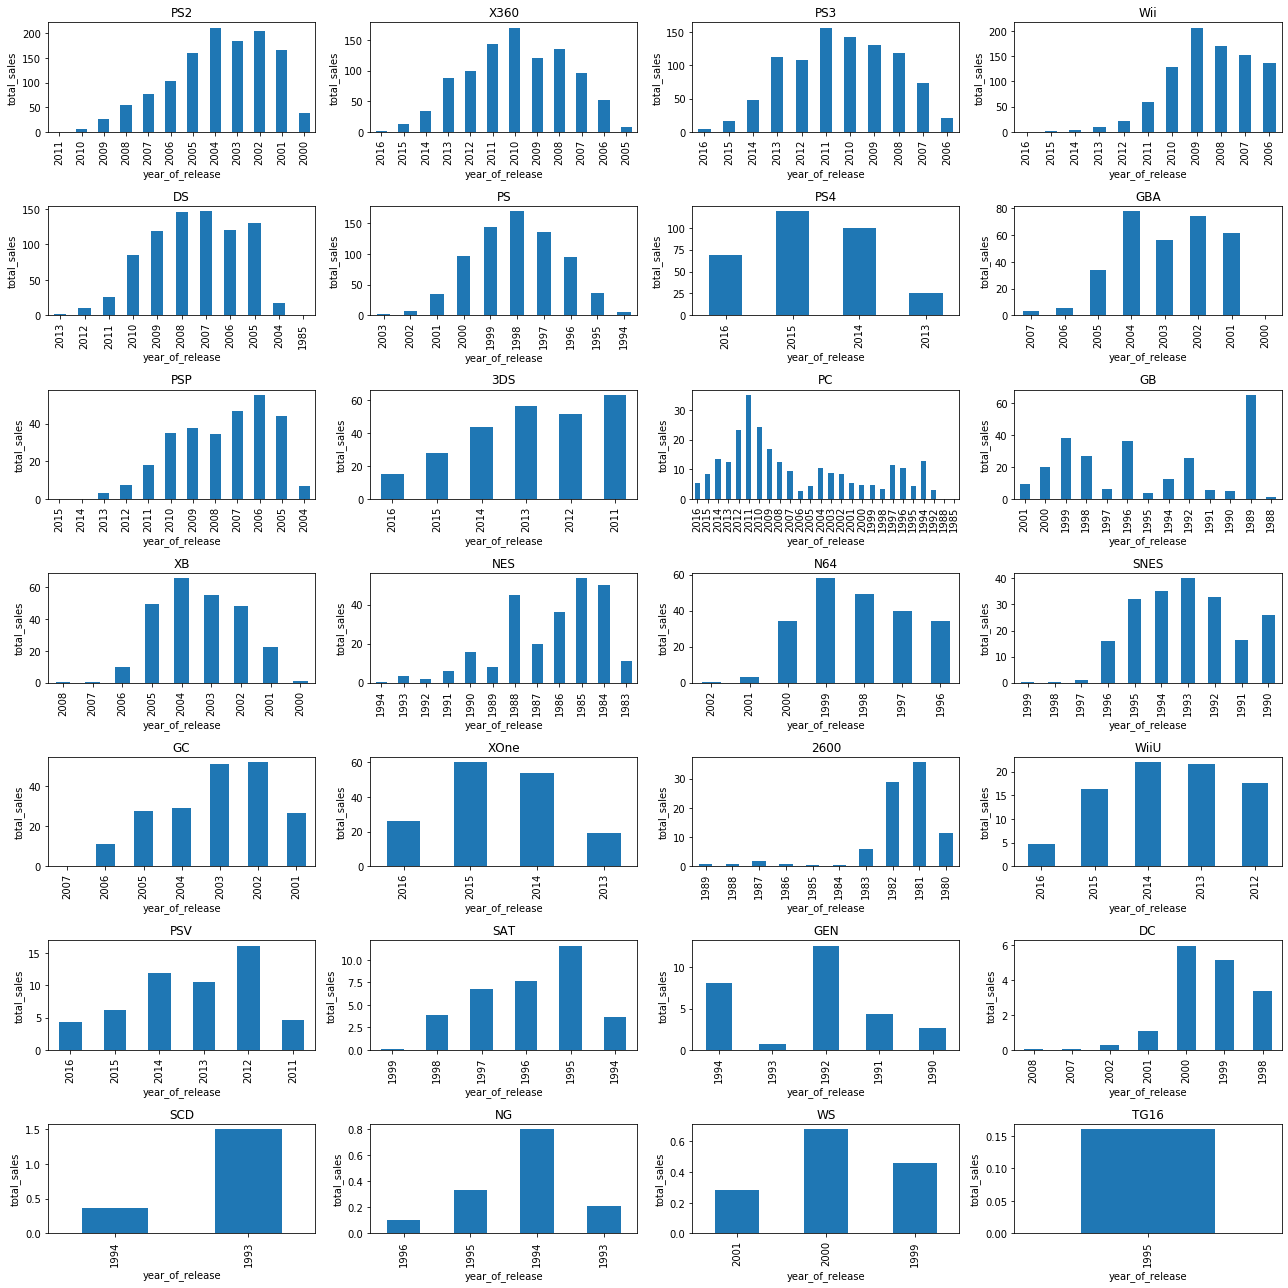

In [8]:
#Total sales per platform
sales_per_platform = games.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum').sort_values('total_sales', ascending = False)

platforms = list(sales_per_platform.index)

#Plot total sales per platform
fig, axs = plt.subplots(7, len(platforms) // 7)
axs = axs.flatten()

num = 0
for platform, ax in zip(platforms, axs):
    ((games[games['platform'] == platform]
         .pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum')
         .sort_values('year_of_release', ascending = False))['total_sales']
            .plot(kind = 'bar', ax = ax, figsize = (18,18), title = platform)
            .set(xlabel = 'year_of_release', ylabel = 'total_sales'))

plt.tight_layout()
plt.show()

To show the total sales per year per platform, we created subplots for each platform. For each subplot the x axis is year of release and the y axis is total sales. Some games that use to be popular but now have 0 sales are PS2, GC, XB, and PS.

### How Long It Takes for New Platforms to Appear and Old Ones to Fade

In [9]:
#Average time of platforms
fadeTimePerPlatform = (games.groupby('platform')['year_of_release'].max() - games.groupby('platform')['year_of_release'].min()).reset_index()
averageFadeTime = fadeTimePerPlatform['year_of_release'].mean().round(decimals=1)
display(averageFadeTime)

7.6

The average time it takes for new platforms to appear and old ones to fade is about 7.6 years.

### Determine the Period to Take Data From

In [10]:
#Data from 2005 and on
games = games.query('2012 <= year_of_release')
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NA,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NA,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


As you can see from the bar graphs in step 3.4 games are only relevant for 3-5 years after they are released. To find what years of data we will be analysing we subtract 3-5 years from our analysis year, 2017. The most relevant data is between 2012 and 2014. We will keep data with a year of release from 2012 to 2016. This will help us determine the best campaign for 2017.

### Determine Which Platforms are Leading in Sales

Text(0.5, 1.0, 'Total Sales per Platform')

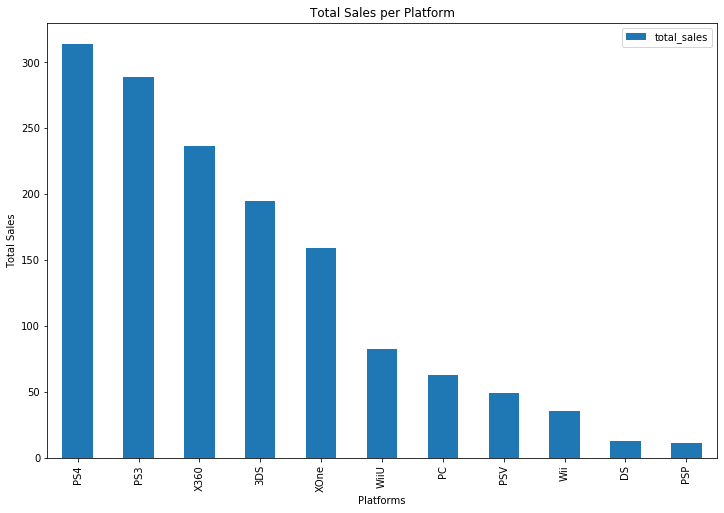

In [11]:
#Total sales per platform
sales_per_platform = games.pivot_table(index = 'platform', values = 'total_sales',
                                 aggfunc = 'sum').sort_values(by = 'total_sales', ascending = False).reset_index()

#Remove platforms with zero total sales

#Plot of total sales per platform
sales_per_platform.plot(kind = 'bar', x = 'platform', y = 'total_sales', figsize = (12,8))
plt.ylabel('Total Sales')
plt.xlabel('Platforms')
plt.title('Total Sales per Platform')

To find the leading sales per platform we made a bar graph by adding up all the total sales for each platform. The platforms leading in total sales are PS4, PS3, Xbox360, Wii, and 3DS. 

### Determine Which Platforms are Growing or Shrinking

Text(0.5, 1, 'Sales Sucess or Drop')

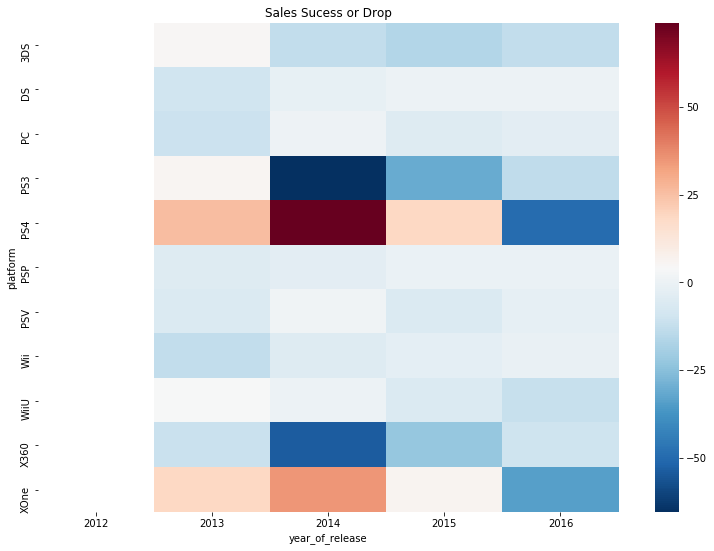

In [12]:
#Platforms growing or shrinking
grow_shrink = games.pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales',
                                   aggfunc = 'sum', fill_value=0)
dynamics = grow_shrink - grow_shrink.shift(+1)
#plot dynamics of grow and shrink
plt.figure(figsize=(13,9))
sns.heatmap(dynamics.T,cmap='RdBu_r')

plt.title('Sales Sucess or Drop')

We created a heat map to show the sales success or drop of each platform per year. The x axis is year of release and the y axis is platforms. The map shows the increase in sales or decrease in sales for each platform where red means increase and blue means decrease. The platforms shrinking are PSP, DS, and Wii. The platforms growing are PS4 and XOne. Some platforms that are potentially profitable are PS4 and XOne.

### Global Sales for All Games Broken Down By Platform

,platform,year_of_release,total_sales
0,PS4,2015,118.90
1,PS3,2013,113.25
2,PS3,2012,107.36
3,PS4,2014,100.00
4,X360,2012,99.74


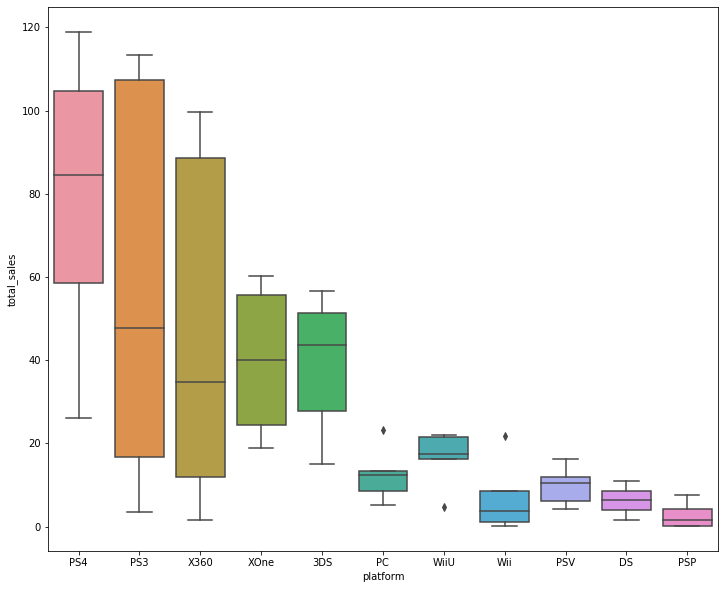

In [13]:
#Total sales for all games per platform
global_sales = games.pivot_table(index = ['platform', 'year_of_release'], values = 'total_sales',
                                 aggfunc = 'sum').sort_values(by = 'total_sales', ascending = False).reset_index()
display(global_sales.head())

#Plot for total sales for all games per platform
plt.figure(figsize = (12, 10))
sns.boxplot(x = 'platform', y = 'total_sales', data = global_sales)

We built a box plot to find global sales of all games, broken down by platform. The difference in sales is significant. Games sold on X360, XOne, PS3, 3DS, and PS4 are significantly more profitable than games sold on other platforms. The average sales of the PS4 are much higher than the rest. The average sales on PS3, X360, XOne, and 3DS. are most comparable. Wii, PSV, PC, DS, PSP and WiiU have the lowest average global sales.

### How User and Professional Reviews Affect Sales on PS3

Correlation between user score and total sales:  0.01
Correlation between critic score and total sales:  0.29


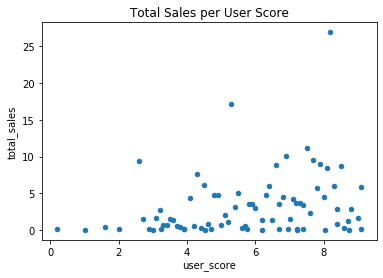

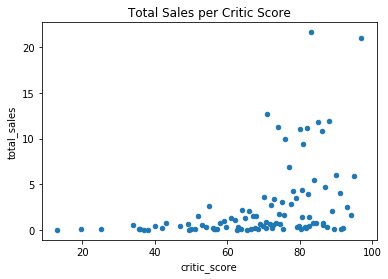

In [14]:
#Filter out PS3 games
PS3_games = games[games['platform'] == 'PS3']

#Pivot table for total_sales per user score
PS3_sales_user = PS3_games.pivot_table(index = 'user_score', values = 'total_sales',
                                  aggfunc = 'sum').reset_index().sort_values(by = 'user_score', ascending = False)
PS3_sales_user.head()

#Plot total sales per user score
PS3_sales_user.plot(kind = 'scatter', x = 'user_score', y = 'total_sales', figsize = (6,4))
plt.title('Total Sales per User Score')

#Pivot table for total_sales per critic score
PS3_sales_critic = PS3_games.pivot_table(index = 'critic_score', values = 'total_sales',
                                  aggfunc = 'sum').reset_index().sort_values(by = 'critic_score', ascending = False)
PS3_sales_critic.head()

#Plot total sales per critic score
PS3_sales_critic.plot(kind = 'scatter', x = 'critic_score', y = 'total_sales', figsize = (6,4))
plt.title('Total Sales per Critic Score')

#Calculate the correlation between reviews and sales on PS3
corr_user = games['user_score'].corr(games['total_sales'])
print('Correlation between user score and total sales: ', corr_user.round(2))
corr_critic = games['critic_score'].corr(games['total_sales'])
print('Correlation between critic score and total sales: ', corr_critic.round(2))

We looked at how user and professional reviews affect the sales on PS3 games. The higher the reviews for the game the more profit the game makes. This is true for both user and critic reviews. Since the correlation between critic scores and total sales is higher than user scores and total sales, it can be said that buyers trust critic ratings more than user ratings.

### Compare the Sales of the Same Games on Other Platforms

Correlation between user score and total sales for (X360, PS2, PS4, Wii):  0.2
Correlation between critic score and total sales for (X360, PS2, PS4, Wii)::  0.42


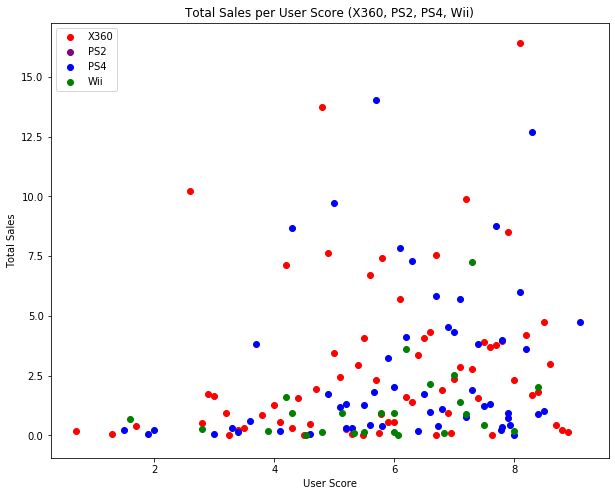

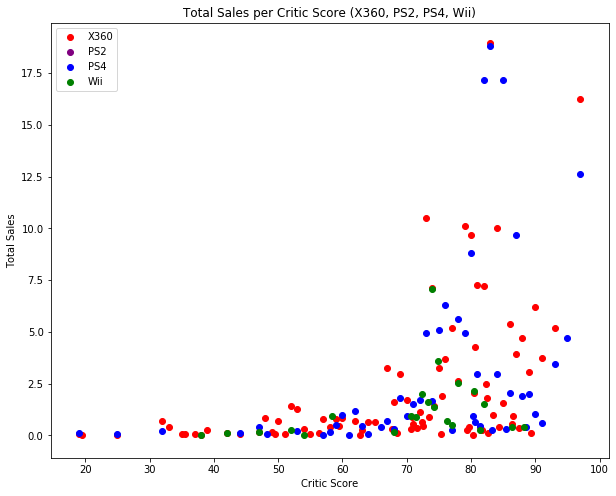

In [15]:
#List of PS3 games
PS3games = PS3_games['name'].unique().tolist()
#List of other platforms
other_platforms = games.query('platform in ("X360", "PS2", "PS4", "Wii") and name in @PS3games')
other_platforms.head(50)

#Plot sales per critic score (X360, PS2, PS4, Wii)
other_platforms_user = other_platforms.groupby(['platform', 'user_score'])['total_sales'].sum().reset_index()
fig, axes = plt.subplots(figsize = (10,8))
platforms = ['X360', 'PS2', 'PS4', 'Wii']
colors = ['red', 'purple', 'blue', 'green']
i = 0
for platform in platforms:
    user = other_platforms_user[other_platforms_user['platform'] == platform]
    axes.scatter(user['user_score'], user['total_sales'], c = colors[i], label = platform)
    i += 1

axes.legend(loc = 'upper left')
axes.set_title('Total Sales per User Score (X360, PS2, PS4, Wii)')
axes.set_xlabel('User Score')
axes.set_ylabel('Total Sales')

#Plot sales per critic score (X360, PS2, PS4, Wii)
other_platforms_critic = other_platforms.groupby(['platform', 'critic_score'])['total_sales'].sum().reset_index()
fig, axes = plt.subplots(figsize = (10,8))
platforms = ['X360', 'PS2', 'PS4', 'Wii']
colors = ['red', 'purple', 'blue', 'green']
i = 0
for platform in platforms:
    critic = other_platforms_critic[other_platforms_critic['platform'] == platform]
    axes.scatter(critic['critic_score'], critic['total_sales'], c = colors[i], label = platform)
    i += 1

axes.legend(loc = 'upper left')
axes.set_title('Total Sales per Critic Score (X360, PS2, PS4, Wii)')
axes.set_xlabel('Critic Score')
axes.set_ylabel('Total Sales')

#Calculate the correlation between reviews and sales for other platforms
corr_user_other = other_platforms_user['user_score'].corr(other_platforms_user['total_sales'])
print('Correlation between user score and total sales for (X360, PS2, PS4, Wii): ', corr_user_other.round(2))
corr_critic_other = other_platforms_critic['critic_score'].corr(other_platforms_critic['total_sales'])
print('Correlation between critic score and total sales for (X360, PS2, PS4, Wii):: ', corr_critic_other.round(2))

We chose X360, PS2, PS4, and Wii to compare the total sales to user and critic reviews. Just as it was with the PS3, the higher the reviews for both critic and users the more profit the game makes. The correlation value between critic scores and total sales was still higher than user scores and total sales. Buyers still prefer critic reviews on other platforms.

### Distribution of Games by Genre

Text(0.5, 1.0, 'Total Sales by Genre')

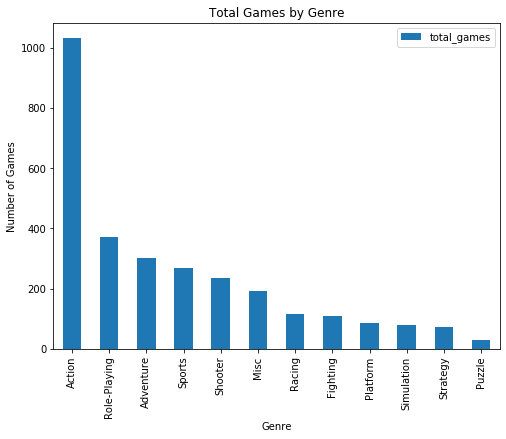

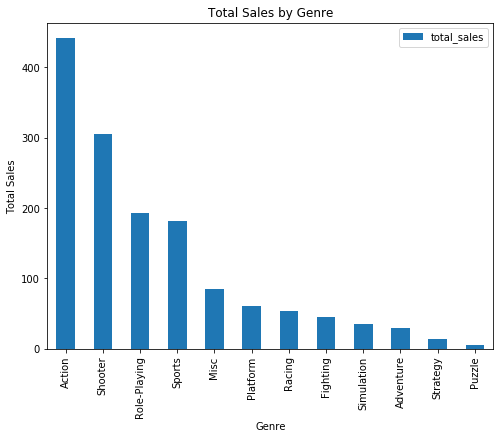

In [16]:
#Games released by genre
games_per_genre = games.groupby('genre')['name'].count().reset_index().sort_values(by = 'name', ascending = False)
games_per_genre.columns = ['genre', 'total_games']
games_per_genre.head()

#Plot games released by genre
games_per_genre.plot(kind = 'bar', x = 'genre', y = 'total_games', figsize = (8, 6))
plt.xlabel('Genre')
plt.ylabel('Number of Games')
plt.title('Total Games by Genre')

#Total sales by genre
genre_sales = games.groupby('genre')['total_sales'].sum().reset_index().sort_values(by = 'total_sales', ascending = False)
genre_sales.head()

#Plot games released by genre
genre_sales.plot(kind = 'bar', x = 'genre', y = 'total_sales', figsize = (8, 6))
plt.xlabel('Genre')
plt.ylabel('Total Sales')
plt.title('Total Sales by Genre')


The most popular genre, action, is also the most profitable. The most popular genres per game are action, role-playing, adventure and sports. The most profitable genres are action, shooter, role-playing and sports. The least popular genres (puzzle and strategy) are the least profitable.

## Create a User Profile for Each Region

### The Top Five Platforms for Each Region (NA, EU, JP)

Text(0.5, 1.0, 'Japan (JP) Sales per Platform')

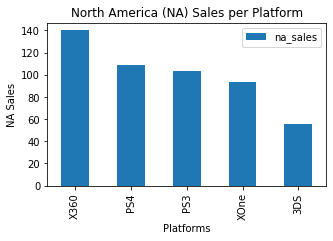

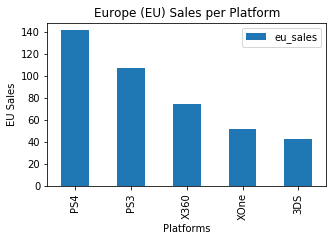

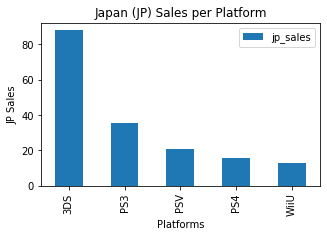

In [17]:
#North America (NA) top platforms
na_platforms = games.pivot_table(index = 'platform', values = 'na_sales',
                                 aggfunc = 'sum').sort_values(by = 'na_sales', ascending = False).reset_index().head()
na_platforms.head()
#Plot North America (NA) top platforms
na_platforms.plot(kind = 'bar', x = 'platform', y = 'na_sales', figsize = (5,3))
plt.ylabel('NA Sales')
plt.xlabel('Platforms')
plt.title('North America (NA) Sales per Platform')


#North America (NA) top platforms
eu_platforms = games.pivot_table(index = 'platform', values = 'eu_sales',
                                 aggfunc = 'sum').sort_values(by = 'eu_sales', ascending = False).reset_index().head()
eu_platforms.head()
#Plot North America (NA) top platforms
eu_platforms.plot(kind = 'bar', x = 'platform', y = 'eu_sales', figsize = (5,3))
plt.ylabel('EU Sales')
plt.xlabel('Platforms')
plt.title('Europe (EU) Sales per Platform')


#North America (NA) top platforms
jp_platforms = games.pivot_table(index = 'platform', values = 'jp_sales',
                                 aggfunc = 'sum').sort_values(by = 'jp_sales', ascending = False).reset_index().head()
jp_platforms.head()

#Plot North America (NA) top platforms
jp_platforms.plot(kind = 'bar', x = 'platform', y = 'jp_sales', figsize = (5,3))
plt.ylabel('JP Sales')
plt.xlabel('Platforms')
plt.title('Japan (JP) Sales per Platform')

The most popular platforms for North America (NA) are X360, PS3, 3DS, PS4, and XOne. North America's most profitable platform is X360. Europe's (EU) most popular platforms are PS3, X360, PS4, 3DS, and PC. Europe's top selling platform is the PS4. The top most profitable platforms are the same in North America and Europe. The most popular platforms in Japan (JP) are 3DS, PS3, PSV, PS4, and WiiU. Based on the top platforms, Japan prefers handheld platforms.

### The Top Five Genres for Each Region (NA, EU, JP)

Text(0.5, 1.0, 'Japan (JP) Sales per Genre')

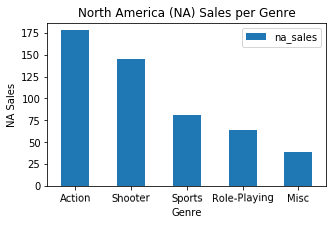

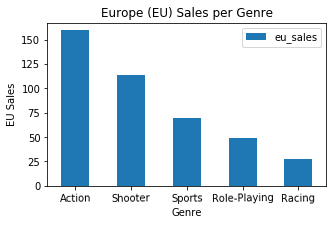

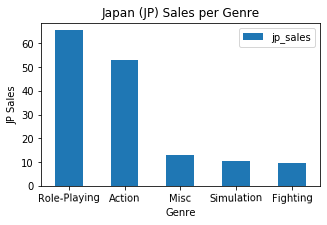

In [18]:
#North America (NA) top five genres
na_genre = games.pivot_table(index = 'genre', values = 'na_sales',
                                 aggfunc = 'sum').sort_values(by = 'na_sales', ascending = False).reset_index().head()
na_genre.head()
#Plot North America (NA) top five genres
na_genre.plot(kind = 'bar', x = 'genre', y = 'na_sales', figsize = (5,3), rot = 1)
plt.ylabel('NA Sales')
plt.xlabel('Genre')
plt.title('North America (NA) Sales per Genre')


#Europe (EU) top five genres
eu_genre = games.pivot_table(index = 'genre', values = 'eu_sales',
                                 aggfunc = 'sum').sort_values(by = 'eu_sales', ascending = False).reset_index().head()
eu_genre.head()
#Plot Europe (EU) top five genres
eu_genre.plot(kind = 'bar', x = 'genre', y = 'eu_sales', figsize = (5,3), rot = 1)
plt.ylabel('EU Sales')
plt.xlabel('Genre')
plt.title('Europe (EU) Sales per Genre')


#Japan (JP) top five genres
jp_genre = games.pivot_table(index = 'genre', values = 'jp_sales',
                                 aggfunc = 'sum').sort_values(by = 'jp_sales', ascending = False).reset_index().head()
jp_genre.head()
#Plot Europe (EU) top five genres
jp_genre.plot(kind = 'bar', x = 'genre', y = 'jp_sales', figsize = (5,3), rot = 1)
plt.ylabel('JP Sales')
plt.xlabel('Genre')
plt.title('Japan (JP) Sales per Genre')

The top five genres for North America (NA) are action, shooter, sports, misc, and role-playing. Europe's (EU) top 5 genres are action, shooter, sports, role_playing, and racing. North America's and Europe's top four are the same. Japan differs from the other two regions, with the top five genres being role-playing, action, misc, simulation, and fighting.

### ESRB Ratings Affect on Sales for Each Region (NA, EU, JP)

Text(0.5, 1.0, 'Japan Sales per Rating')

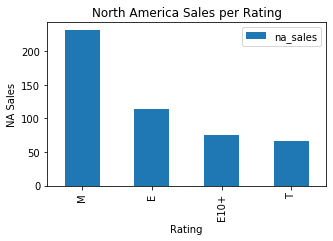

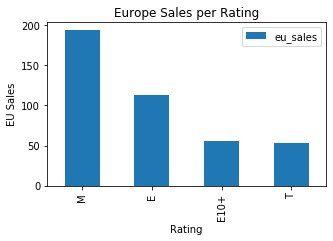

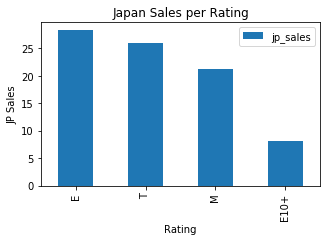

In [19]:
#North America (NA) top ratings
na_ratings = games.pivot_table(index = 'rating', values = 'na_sales',
                                 aggfunc = 'sum').sort_values(by = 'na_sales', ascending = False).reset_index()
na_ratings = na_ratings[na_ratings['rating'] != "NA"]
na_ratings.head()
#Plot North America (NA) top platforms
na_ratings.plot(kind = 'bar', x = 'rating', y = 'na_sales', figsize = (5,3))
plt.ylabel('NA Sales')
plt.xlabel('Rating')
plt.title('North America Sales per Rating')


#Europe (EU) top ratings
eu_ratings = games.pivot_table(index = 'rating', values = 'eu_sales',
                                 aggfunc = 'sum').sort_values(by = 'eu_sales', ascending = False).reset_index()
eu_ratings = eu_ratings[eu_ratings['rating'] != "NA"]
eu_ratings.head()
#Plot Europe (EU) top ratings
eu_ratings.plot(kind = 'bar', x = 'rating', y = 'eu_sales', figsize = (5,3))
plt.ylabel('EU Sales')
plt.xlabel('Rating')
plt.title('Europe Sales per Rating')


#Japan (JP) top ratings
jp_ratings = games.pivot_table(index = 'rating', values = 'jp_sales',
                                 aggfunc = 'sum').sort_values(by = 'jp_sales', ascending = False).reset_index()
jp_ratings = jp_ratings[jp_ratings['rating'] != "NA"]
jp_ratings.head()

#Plot Japan (JP) top ratings
jp_ratings.plot(kind = 'bar', x = 'rating', y = 'jp_sales', figsize = (5,3))
plt.ylabel('JP Sales')
plt.xlabel('Rating')
plt.title('Japan Sales per Rating')

Games that have an ESRB rating of M are most popular in North American (NA) and Europe (EU). Japan's most profitable games have a rating of E.

## Test Hypotheses

### Test Hypothesis Average User Ratings of the Xbox One and PC Platforms are the Same

In [20]:
#Xbox One data
xbox_games = games.query('platform == "XOne"')
#Remove missing values
xbox_games = xbox_games[xbox_games['user_score'].notna()]
xbox_games.head()
#Average user rating
ratings_xbox = xbox_games['user_score'].mean().round(2)
print('The average user ratings of Xbox One games are:', ratings_xbox)


#PC data
pc_games = games.query('platform == "PC"')
#Remove missing values
pc_games = pc_games[pc_games['user_score'].notna()]
pc_games.head()
#Average user rating
ratings_pc = pc_games['user_score'].mean().round(2)
print('The average user ratings of PC games are:', ratings_pc)

#Perform a t-test
alpha = 0.05
results = st.ttest_ind(pc_games['user_score'], xbox_games['user_score'], equal_var = False)
print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print('We reject the null hypothesis')
else:
    print("We can't reject the null hypothesis")

The average user ratings of Xbox One games are: 6.59
The average user ratings of PC games are: 6.43
p-value:  0.2775307855304285
We can't reject the null hypothesis


We tested the hypothesis that average user ratings of the xbox one and pc platforms are the same. To do so we used an independent samples t-test to comapre the average user ratings of both xbox one and pc games. 

The null hypothesis H0, states that the average user rating of xbox one games is similar to the average user rating of pc games. The alternative hypothesis H1, states that the average user rating of xbox one games differ from the average user rating of pc games.

The value obtained from the t-test suggests that we can not reject the null hypothesis. Average user rating of xbox one games are similar to the average user rating of pc games.

### Test Hypothesis Average User Ratings for the Action and Sports Genres are Different

In [21]:
#Action genre data
action_games = games.query('genre == "Action"')
#Remove missing values
action_games = action_games[action_games['user_score'].notna()]
action_games.head()
#Average user rating
ratings_action = action_games['user_score'].mean().round(2)
print('The average user ratings of action games are:', ratings_action)


#Sports genre data
sports_games = games.query('genre == "Sports"')
#Remove missing values
sports_games = sports_games[sports_games['user_score'].notna()]
sports_games.head()
#Average user rating
ratings_sports = sports_games['user_score'].mean().round(2)
print('The average user ratings of sports games are:', ratings_sports)

#Perform a t-test
alpha = 0.05
results = st.ttest_ind(sports_games['user_score'], action_games['user_score'], equal_var = False)
print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print('We reject the null hypothesis')
else:
    print("We can't reject the null hypothesis")

The average user ratings of action games are: 6.84
The average user ratings of sports games are: 5.42
p-value:  6.145950453209797e-25
We reject the null hypothesis


We want to test if the average user rating of action games is different than the average user rating of sports games. Just as in the previous section this is done by an independent samples t-test to compare the average user rating for both action and sports genres. 

The null hypothesis H0, states the average user rating of action games is similiar to the average user rating of sports games. The alternative hypothesis H1, states the average user rating of action games differs from the average user rating of sports games.

The p-value found verifys that we can reject the null hypothesis. The average user rating of action games differs from the average user rating of sports games.

## Conclusion

Not all missing values were fill in. The rows that still have missing values are 'critic_score', 'user_score', and 'rating'. There was no logical way to fill in the values. We believe the values are missing due to human error.

After analyzing the data we decided to remove games that were released between 2012-2016. Games between 2012-2014 are most relevant since a game stays relevant for three to five years after it is released.

The highest profiting platforms are PS4, PS3, and Xbox360. Some platforms that are growing are the PS4 and Xbox One. The platforms that are shrinking are Wii, PSP, DS. Games sold on platforms such as PS4, PS3, X360, XOne, and 3DS are significantly more profitable than other systems. Games with higher user and critic reviews make more profit. However, buyers tend to trust critic reviews more than user reviews. The most popular and profitable games are action games that have an ESRB rating of M.

Based on the data a game that will earn the most profit is an action game with an ESRB rating of M on the PS4 with high rating from both users and critics.